In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt
import warnings
warnings.filterwarnings('ignore')


In [28]:
data=pd.read_csv('FINAL_USO.csv')

In [29]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,...,20.650000,21.090000,21.090000,60507000,9.490000,9.520000,9.280000,9.290000,9.290000,21598200
1714,2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,...,20.530001,20.620001,20.620001,76365200,9.250000,9.920000,9.230000,9.900000,9.900000,40978800
1715,2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,...,20.700001,20.969999,20.969999,52393000,9.590000,9.650000,9.370000,9.620000,9.620000,36578700
1716,2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,...,20.570000,20.600000,20.600000,49835000,9.540000,9.650000,9.380000,9.530000,9.530000,22803400


In [30]:
# Convert the 'Date' column to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

In [31]:
# Select relevant columns (e.g., USO_Close for forecasting)
target_column = 'USO_Close'
data = data[['Date', target_column]].copy()

In [32]:
print(data.isnull().sum())
data.dropna(inplace=True)

Date         0
USO_Close    0
dtype: int64


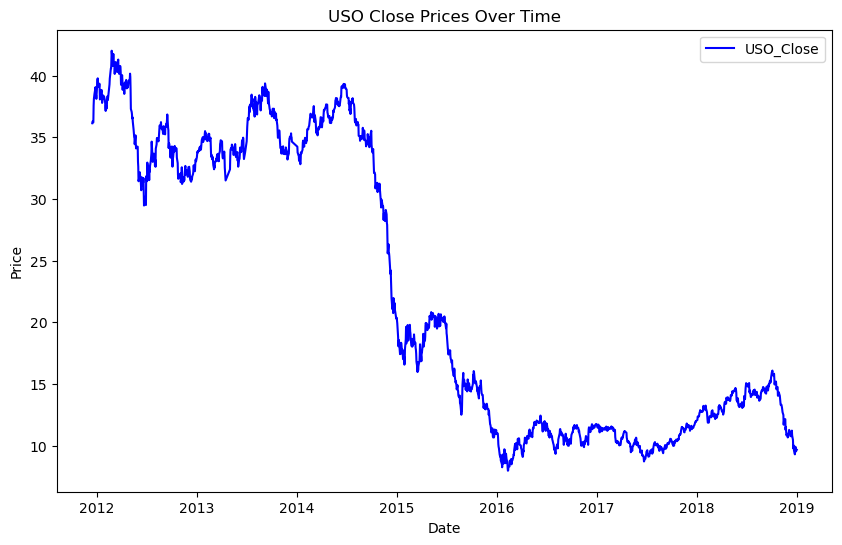

In [33]:
# Visualize the target column
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data[target_column], label='USO_Close', color='blue')
plt.title('USO Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler.fit_transform(data[[target_column]])


In [35]:
# Create a function for generating sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 50


In [36]:
# Prepare the data for training and testing
prices = data[target_column].values
X, y = create_sequences(prices, sequence_length)


In [37]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
# Reshape the data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [39]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [40]:
# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0655 - val_loss: 3.1583e-04
Epoch 2/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0047 - val_loss: 3.2267e-04
Epoch 3/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0040 - val_loss: 2.6436e-04
Epoch 4/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0035 - val_loss: 3.2596e-04
Epoch 5/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0037 - val_loss: 2.7014e-04
Epoch 6/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 2.4730e-04
Epoch 7/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033 - val_loss: 2.5631e-04
Epoch 8/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 2.3561e-04
Epoch 9/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 2.2404e-04
Epoch 10/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027 - val_loss: 2.2658e-04
Epoch 11/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0028 - val_loss: 2.2496e-04
Epoch 12/40
42/42 ━

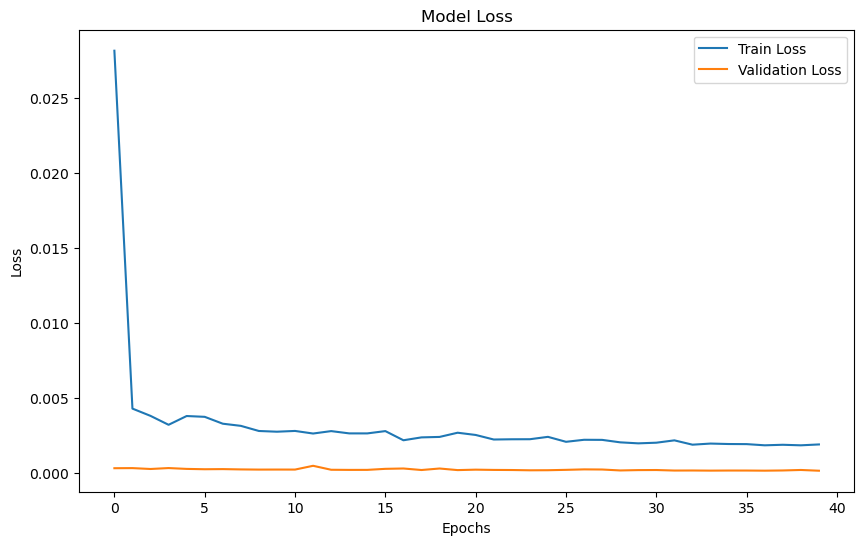

In [41]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [43]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")


Root Mean Squared Error: 0.42


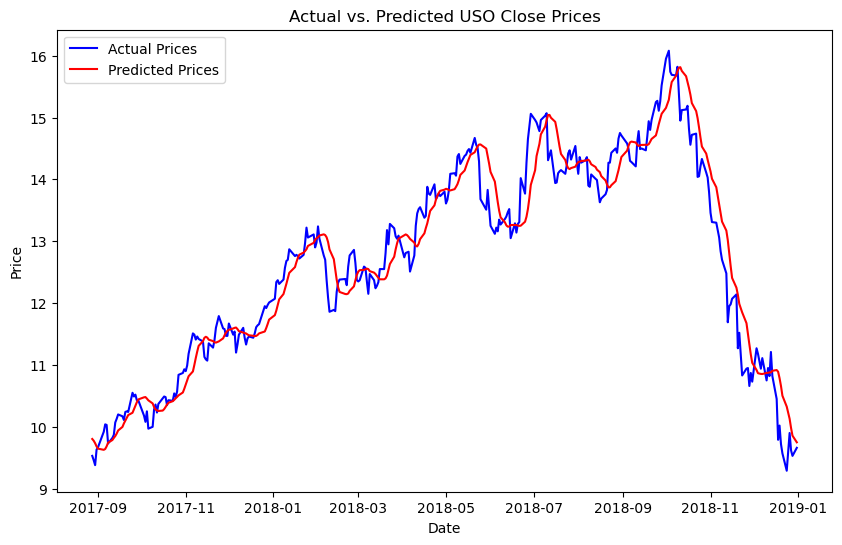

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(data['Date'][-len(y_test):], y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs. Predicted USO Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()